In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd

In [2]:
mnist_data = pd.read_csv("mnist-data/digits.csv")

In [3]:
x = np.random.randn(10,28,28,3)
w = np.random.randn(3,3,3,16)
b = np.random.randn(1,1,1,16)

In [4]:
def pool_forward(x,mode="max"):
    #m*n_c*w*h
    x_patches = x.reshape(x.shape[0],x.shape[1]//2, 2,x.shape[2]//2, 2,x.shape[3])
    if mode=="max":
        out = x_patches.max(axis=2).max(axis=3)
        mask  =np.isclose(x,np.repeat(np.repeat(out,2,axis=1),2,axis=2)).astype(int)
    elif mode=="average": 
        out =  x_patches.mean(axis=3).mean(axis=4)
        mask = np.ones_like(x)*0.25
    return out,mask

In [5]:
def pool_backward(dx, mask):
    return mask*(np.repeat(np.repeat(dx,2,axis=1),2,axis=2))

In [6]:
def relu(x, deriv=False):
    if deriv:
        return (x>0)
    return np.multiply(x, x>0)

In [7]:
def conv_forward(x,w,b,padding="same"):
    if padding=="same": 
        pad = (w.shape[0]-1)//2
    else: #padding is valid - i.e no zero padding
        pad =0 
    n = (x.shape[1]-w.shape[0]+2*pad) +1 #ouput width/height
    y = np.zeros((x.shape[0],n,n,w.shape[3]))
    x = np.pad(x,((0,0),(pad,pad),(pad,pad),(0,0)),'constant', constant_values = 0)
    w = np.flip(w,0)
    w = np.flip(w,1)
    
    f = w.shape[0]
        
    for i in range(x.shape[0]):
        for k in range(w.shape[3]):
            for d in range(x.shape[3]):
                y[i,:,:,k]+=ndimage.convolve(x[i,:,:,d],w[:,:,d,k])[f//2:-(f//2),f//2:-(f//2)]
                #ndimage.convolve starts convolution from centre of kernel and zero pads but we don't want this
                #since we want to manually decide if we want to pad or not
    y = y + b
    return y

In [8]:
def fc_forward(x,w,b):
    return relu(w.dot(x)+b)


In [9]:
def fc_backward(dA,z,x,w,b):
    m = dA.shape[1]
    dZ = dA*relu(z, deriv = True)
    dW = (1/m)*dZ.dot(x.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dx =  np.dot(w.T,dZ)
    return dx, dW,db

In [10]:
def softmax_forward(x,w,b):
    z = w.dot(x)+b
    z-= np.mean(z,axis=0)
    return np.exp(z)/np.sum(np.exp(z),axis=0)

In [11]:
def softmax_backward(y_hat, y, w, b, x):
    m = y.shape[1]
    dZ = y_hat - y
    dW = (1/m)*dZ.dot(x.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dx =  np.dot(w.T,dZ)
    return dx, dW,db

In [12]:
def conv_backward(dZ,x,w,padding="same"):
    m = x.shape[0]
    db = (1/m)*np.sum(dZ, axis=(0,1,2), keepdims=True)
    
    if padding=="same": 
        pad = (w.shape[0]-1)//2
    else: #padding is valid - i.e no zero padding
        pad =0 
    x_padded = np.pad(x,((0,0),(pad,pad),(pad,pad),(0,0)),'constant', constant_values = 0)
    
    #this will allow us to broadcast operation
    x_padded_bcast = np.expand_dims(x_padded, axis=-1) 
    dZ_bcast = np.expand_dims(dZ, axis=-2)
    
    dW = np.zeros_like(w)
    f=w.shape[0]
    w_x = x_padded.shape[1]
    for i in range(f):
        for j in range(f):
            dW[i,j,:,:] = (1/m)*np.sum(dZ_bcast*x_padded_bcast[:,i:w_x-(f-1 -i),j:w_x-(f-1 -j),:,:],axis=(0,1,2))  
    
    dx = np.ones_like(x_padded)*0.0
    Z_pad = f-1
    dZ_padded = np.pad(dZ,((0,0),(Z_pad,Z_pad),(Z_pad,Z_pad),(0,0)),'constant', constant_values = 0)  
    for i in range(x.shape[0]):
        for k in range(w.shape[3]):
            for d in range(x.shape[3]):
                dx[i,:,:,d]+=ndimage.convolve(dZ_padded[i,:,:,k],w[:,:,d,k])[f//2:-(f//2),f//2:-(f//2)]
    dx = dx[:,pad:dx.shape[1]-pad,pad:dx.shape[2]-pad,:]
    return dx,dW,db

Next to define the model:


In [13]:
def init_conv_parameters(f, n_c, k):
    return 0.001*np.random.rand(f,f,n_c,k), np.random.rand(1,1,1,k)+1
def init_fc_parameters(n_x,n_y):
    return 0.001*np.random.rand(n_y,n_x),np.random.rand(n_y,1)+1

In [14]:
def initialise_parameters():    
    parameters={}
    parameters["W_conv1"], parameters["b_conv1"] = init_conv_parameters(5, 1, 16)
    #parameters["W_conv2"], parameters["b_conv2"] = init_conv_parameters(3, 16, 16)

   # parameters["W_conv3"], parameters["b_conv3"] = init_conv_parameters(3, 16, 32)
   # parameters["W_conv4"], parameters["b_conv4"] = init_conv_parameters(3, 32,32)

    parameters["W_fc1"],parameters["b_fc1"] = init_fc_parameters(3136,512)
    parameters["W_softmax"],parameters["b_softmax"] = init_fc_parameters(512,10)

    return parameters


In [15]:
def forward_prop(X,parameters):
    
    cache={}
    
    cache["z_conv1"] = conv_forward(X,parameters["W_conv1"], parameters["b_conv1"])
    cache["a_conv1"] = relu(cache["z_conv1"])

    #cache["z_conv2"] = conv_forward(cache["a_conv1"],parameters["W_conv2"], parameters["b_conv2"])
    #cache["a_conv2"] = relu(cache["z_conv2"])

   # cache["z_pool1"], cache["mask_pool1"] = pool_forward(cache["a_conv2"])
    
 

   # cache["z_conv3"] = conv_forward(cache["z_pool1"],parameters["W_conv3"], parameters["b_conv3"])
   # cache["a_conv3"] = relu(cache["z_conv3"])
    
 

   # cache["z_conv4"] = conv_forward(cache["a_conv3"],parameters["W_conv4"], parameters["b_conv4"] )
  #  cache["a_conv4"] = relu(cache["z_conv4"])
    
 
  #  cache["z_pool2"], cache["mask_pool2"] = pool_forward(cache["a_conv4"])
    cache["z_pool2"], cache["mask_pool2"] = pool_forward(cache["a_conv1"])


 

    cache["a_flatten"] = np.reshape(cache["z_pool2"], (cache["z_pool2"].shape[0],-1)).T
    #cache["a_flatten"] = np.reshape(cache["a_conv2"], (cache["a_conv2"].shape[0],-1)).T


 
    cache["a_fc1"] = fc_forward( cache["a_flatten"],parameters["W_fc1"],parameters["b_fc1"])
    
 
    return softmax_forward(cache["a_fc1"],parameters["W_softmax"],parameters["b_softmax"]),cache

In [26]:
def backprop(X,Y,Y_pred,parameters,cache,lambd):
    grads = {}
    
    dA, grads["dW_softmax"],grads["db_softmax"] =softmax_backward(Y_pred, Y, parameters["W_softmax"],parameters["b_softmax"],cache["a_fc1"])

    dA, grads["dW_fc1"],grads["db_fc1"] = fc_backward(dA,cache["a_fc1"],cache["a_flatten"],parameters["W_fc1"],parameters["b_fc1"])
    
    dA = np.reshape(dA,cache["z_pool2"].shape)
    dA = pool_backward(dA, cache["mask_pool2"])
    
    #dA = dA*relu(cache["z_conv3"],deriv=True)
   # dA, grads["dW_conv4"],grads["db_conv4"] = conv_backward(dA,cache["a_conv3"],parameters["W_conv4"])
    
   # dA = dA*relu(cache["z_conv3"],deriv=True)
   # dA, grads["dW_conv3"],grads["db_conv3"] = conv_backward(dA,cache["z_pool1"],parameters["W_conv3"])
    
   # dA = pool_backward(dA, cache["mask_pool1"])
    
    #dA = dA*relu(cache["z_conv2"],deriv=True)
    #dA, grads["dW_conv2"],grads["db_conv2"] = conv_backward(dA,cache["a_conv1"],parameters["W_conv2"])
    
    dA = dA*relu(cache["z_conv1"],deriv=True)
    _, grads["dW_conv1"],grads["db_conv1"] = conv_backward(dA,X,parameters["W_conv1"])
    
    #regularisation term
    for key in grads:
        if "W" in key:
            grads[key]+= (lambd/X.shape[0])*parameters[key[1:]] 
    return grads        

In [27]:
def loss_function(y_pred,y,parameters,lambd):
    cost = 0
    m = y.shape[1]
    L = len(parameters)//2
    cost += (-1/m)*np.sum(y*np.log(y_pred))
    
    regularisation_term = 0
    for key in parameters:
        if "W" in key:
            regularisation_term += np.sum(np.square(parameters[key]))
    
    regularised_cost = cost + (lambd/(2*m))*regularisation_term
    
    return regularised_cost

In [28]:
def accuracy(y_pred,y):
    preds = np.argmax(y_pred,axis=0)
    truth = np.argmax(y,axis=0)
    return np.mean(np.equal(preds,truth).astype(int))

In [29]:
def train_model(X_train, Y_train, X_dev, Y_dev,num_epochs,batch_size,lambd,learning_rate):
    train_costs = []
    dev_evals = []
    
    parameters = initialise_parameters()
    for epoch in range (num_epochs):
        print("Training the model, epoch: " + str(epoch+1))
        #cycle through the entire training set in batches
        for i in range(0,X_train.shape[0]//batch_size):
            
            
            #get the next minibatch to train on
            X_train_minibatch = X_train[i*batch_size:(i+1)*batch_size]
            Y_train_minibatch = Y_train[:,i*batch_size:(i+1)*batch_size]
            
            
            
            #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights
            #and biases. Calculate the cost - used to monitor training
            y_pred, cache = forward_prop(X_train_minibatch,parameters)
            minibatch_cost = loss_function(y_pred,Y_train_minibatch,parameters,lambd)
            minibatch_grads = backprop(X_train_minibatch,Y_train_minibatch,y_pred,parameters, cache,lambd)
            
            
            #update the parameters using gradient descent
            for param in parameters.keys():
                parameters[param] = parameters[param] - learning_rate*minibatch_grads["d"+param]
            
            train_costs.append(minibatch_cost)
            print("Cost after iteration " + str(i*(epoch+1)) + ": " + str(minibatch_cost))
            #periodically output an update on the current cost and performance on the dev set for visualisation
            if(i*(epoch+1)%1000 == 0):
                
                y_dev_pred,_ = forward_prop(X_dev,parameters)
                dev_eval_metric = accuracy(y_dev_pred,Y_dev)
                dev_evals.append(dev_eval_metric)
                print("Accuracy on dev set: "+ str(dev_eval_metric))
    print("Training complete!")
    #return the trained parameters and the visualisation metrics
    return parameters, train_costs, dev_evals 

In [30]:
def evaluate_model(train_costs, dev_evals, parameters,X_train, Y_train, X_dev, Y_dev, X_test, Y_test):
    #plot the graphs of training set error and dev set F1 score
    plt.plot(np.squeeze(train_costs))
    plt.ylabel('Cost')
    plt.xlabel('1000s of Iterations')
    plt.title("Training Set Error")
    plt.show()
    plt.plot(np.squeeze(dev_evals))
    plt.ylabel('F1 score')
    plt.xlabel('1000s of Iterations')
    plt.title("Dev Set Accuracy")
    plt.show()
        
    #For each of the train, dev and test sets, perform a step of forward propagation to obtain the trained model's 
    #predictions and evaluate this with an F1 score.
    y_pred_train,_ = forward_prop(X_train,parameters)
    print("The train set accuracy is: "+str(accuracy(y_pred_train,Y_train)))
    
    y_pred_dev,_ = forward_prop(X_dev,parameters)
    print("The dev set accuracy is: "+str(accuracy(y_pred_dev,Y_dev)))
    
    y_pred_test,_= forward_prop(X_test,parameters)
    print("The test set F1 score is: "+str(accuracy(y_pred_test,Y_test)))

In [31]:
def run_model(TrainTestDevSets, hyperparameters):
    
    X_train = TrainTestDevSets["X_train"] 
    Y_train = TrainTestDevSets["Y_train"]

    X_dev = TrainTestDevSets["X_dev"]
    Y_dev = TrainTestDevSets["Y_dev"] 
    
    X_test = TrainTestDevSets["X_test"] 
    Y_test = TrainTestDevSets["Y_test"]
    
    num_epochs = hyperparameters["num_epochs"]
    batch_size = hyperparameters["batch_size"]
    lambd = hyperparameters["lambd"]
    learning_rate = hyperparameters["learning_rate"]
    
    parameters, train_costs, dev_evals = train_model(X_train, Y_train, X_dev, Y_dev,num_epochs,batch_size,lambd,learning_rate)         
    evaluate_model(train_costs, dev_evals, parameters,X_train, Y_train, X_dev, Y_dev, X_test, Y_test)
    return parameters

In [32]:
mnist_data = mnist_data.reindex(np.random.permutation(mnist_data.index)) #shuffle data

In [33]:
X = mnist_data.loc[:,mnist_data.columns!="label"].as_matrix()
X = np.reshape(X,(X.shape[0], 28,28,1))
Y = mnist_data.loc[:,["label"]].as_matrix()
Y = np.eye(10)[Y.reshape(-1)].T

In [34]:
hyperparameters={}
hyperparameters["num_epochs"] = 1 #number of passes through the training set
hyperparameters["batch_size"] = 128 #number of examples trained upon in each step of training
hyperparameters["lambd"] = 1 #regularisation parameter 
hyperparameters["learning_rate"] = 1e-5

In [42]:
parameters =train_model(X[:2000],Y[:,:2000],X[2800:3000],Y[:,2800:3000],10,128,0,0.03)

Training the model, epoch: 1
Cost after iteration 0: 2.342667867674307
Accuracy on dev set: 0.105
Cost after iteration 1: 24.215532560797165
Cost after iteration 2: 14.875682895017652
Cost after iteration 3: 2.3579929470464407
Cost after iteration 4: 2.365244440330007
Cost after iteration 5: 2.3970116707316675
Cost after iteration 6: 2.331258868315088
Cost after iteration 7: 2.3822838967754913
Cost after iteration 8: 2.3272779840968574
Cost after iteration 9: 2.2955731875519234
Cost after iteration 10: 2.4148770354467066
Cost after iteration 11: 2.363066433212982
Cost after iteration 12: 2.3218673023813103
Cost after iteration 13: 2.349211263797381
Cost after iteration 14: 2.3083426863907457
Training the model, epoch: 2
Cost after iteration 0: 2.3467546109391275
Accuracy on dev set: 0.125
Cost after iteration 2: 2.3227183181087536
Cost after iteration 4: 2.345983948346587
Cost after iteration 6: 2.342568150146759
Cost after iteration 8: 2.355557468674453
Cost after iteration 10: 2.3860

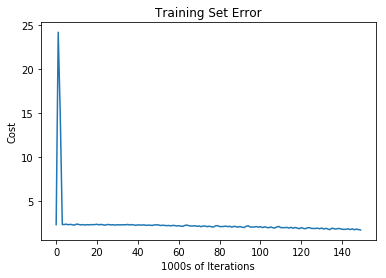

In [43]:
plt.plot(np.squeeze(parameters[1]))
plt.ylabel('Cost')
plt.xlabel('1000s of Iterations')
plt.title("Training Set Error")
plt.show()